In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
real = pd.read_parquet("results/optimized.parquet")

In [29]:
df = pd.read_csv("results/the_final_data.csv")

log2_filter = abs(df["log2_odds_ratio"]) > 0.32
sign_filter = df["p_adj"] < 0.05

df["log2_thresh"] = log2_filter
df["sign_thresh"] = sign_filter
df["both_thresh"] = log2_filter & sign_filter
df['is_gene_upregulated'] = df['log2_odds_ratio'] >= 0

import sqlite3
# add genes table
sqlite_conn = sqlite3.connect('data/mirscribe_backup.db')
genes = pd.read_sql('SELECT * FROM genes', sqlite_conn)
sqlite_conn.close()


# add genes table details
cols_to_merge = ['gene_id', 'tier_cosmic', 'is_hallmark_cosmic','is_oncogene_consensus',
       'is_tsupp_consensus']

df = pd.merge(df, genes[cols_to_merge], how="left", on="gene_id" )

dtypes = {
    'gene_id': 'string',        # More efficient than object for string data
    'tier_cosmic': 'int8',      # Small integer values
    'is_hallmark_cosmic': 'bool',
    'is_oncogene_consensus': 'bool',
    'is_tsupp_consensus': 'bool'
}

# Apply optimized dtypes:
df[cols_to_merge] = df[cols_to_merge].astype(dtypes)


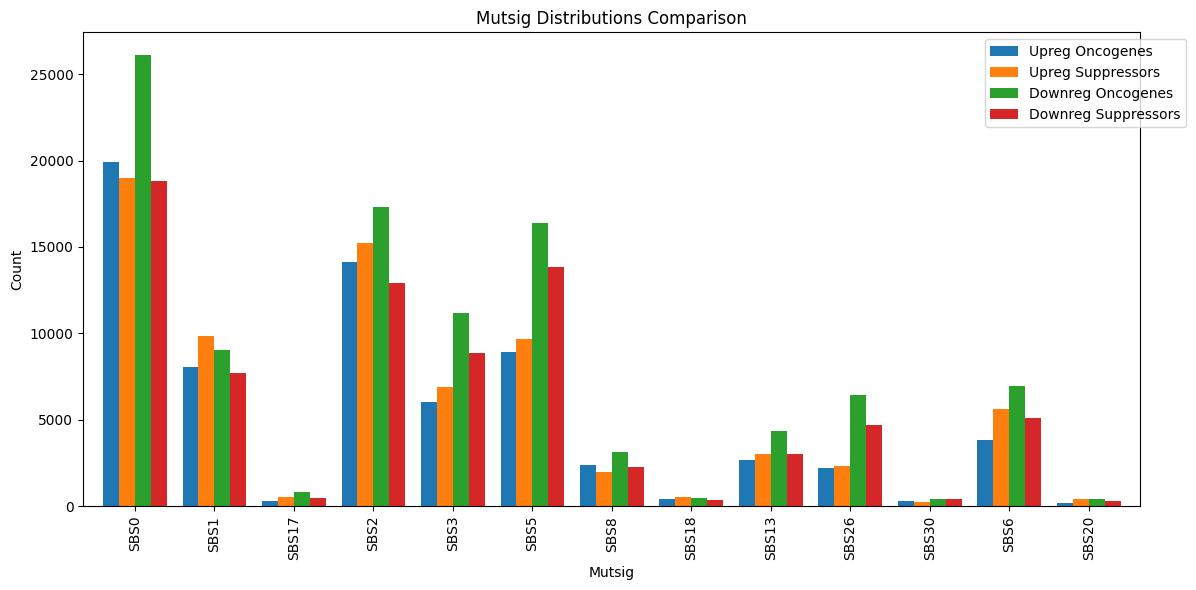

In [46]:
# Create distributions directly with correct filters
up_onc_dist = real[real.gene_id.isin(
    df[df.both_thresh & (df.log2_odds_ratio > 0) & df.is_oncogene_consensus].gene_id)].mutsig.value_counts()

up_tsupp_dist = real[real.gene_id.isin(
    df[df.both_thresh & (df.log2_odds_ratio > 0) & df.is_tsupp_consensus].gene_id)].mutsig.value_counts()

down_onc_dist = real[real.gene_id.isin(
    df[df.both_thresh & (df.log2_odds_ratio < 0) & df.is_oncogene_consensus].gene_id)].mutsig.value_counts()

down_tsupp_dist = real[real.gene_id.isin(
    df[df.both_thresh & (df.log2_odds_ratio < 0) & df.is_tsupp_consensus].gene_id)].mutsig.value_counts()

# Plot
plot_df = pd.DataFrame({
    'Upreg Oncogenes': up_onc_dist,
    'Upreg Suppressors': up_tsupp_dist,
    'Downreg Oncogenes': down_onc_dist,
    'Downreg Suppressors': down_tsupp_dist
})

ax = plot_df.plot(kind='bar', width=0.8, figsize=(12,6))
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Mutsig Distributions Comparison')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [86]:
# Post-hoc test using Tukey's test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Reshape for Tukey
melted_df = plot_df.reset_index().melt(id_vars='mutsig', var_name='Category', value_name='Count')
tukey_results = pairwise_tukeyhsd(melted_df['Count'], melted_df['Category'])
print(tukey_results)


                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
       group1              group2        meandiff  p-adj    lower      upper   reject
-------------------------------------------------------------------------------------
  Downreg Oncogenes Downreg Suppressors -1860.9231 0.8887 -8741.8318 5019.9856  False
  Downreg Oncogenes     Upreg Oncogenes -2592.2308 0.7486 -9473.1395 4288.6779  False
  Downreg Oncogenes   Upreg Suppressors -2116.6923 0.8453  -8997.601 4764.2164  False
Downreg Suppressors     Upreg Oncogenes  -731.3077  0.992 -7612.2164  6149.601  False
Downreg Suppressors   Upreg Suppressors  -255.7692 0.9996 -7136.6779 6625.1395  False
    Upreg Oncogenes   Upreg Suppressors   475.5385 0.9978 -6405.3703 7356.4472  False
-------------------------------------------------------------------------------------


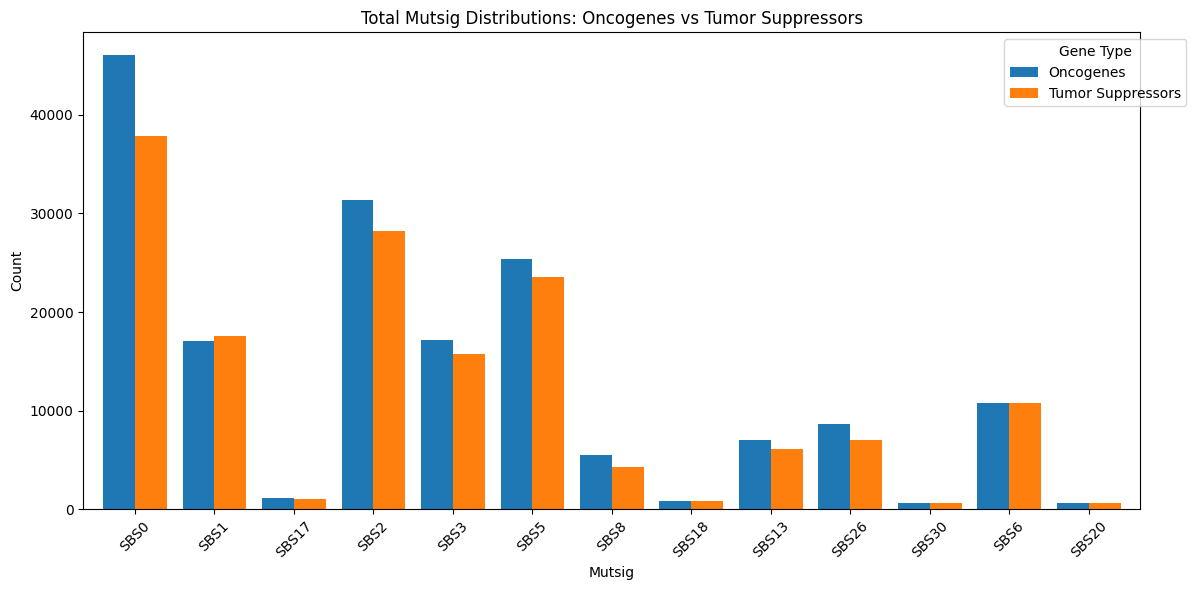

In [91]:
total_onc = up_onc_dist.add(down_onc_dist, fill_value=0)
total_tsupp = up_tsupp_dist.add(down_tsupp_dist, fill_value=0)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Oncogenes': total_onc,
    'Tumor Suppressors': total_tsupp
})

# Fill NaNs with 0 for better plotting
summary_df = summary_df.fillna(0)

# Plot
ax = summary_df.plot(kind='bar', width=0.8, figsize=(12,6))
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Total Mutsig Distributions: Oncogenes vs Tumor Suppressors')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Gene Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
